In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
print(device)

cuda


In [ ]:
file_path = './burgers_shock.mat'
exact_data = loadmat(file_path)

In [ ]:
exact_data

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Wed Sep 20 16:38:22 2017',
 '__version__': '1.0',
 '__globals__': [],
 'x': array([[-1.        ],
        [-0.99215686],
        [-0.98431373],
        [-0.97647059],
        [-0.96862745],
        [-0.96078431],
        [-0.95294118],
        [-0.94509804],
        [-0.9372549 ],
        [-0.92941176],
        [-0.92156863],
        [-0.91372549],
        [-0.90588235],
        [-0.89803922],
        [-0.89019608],
        [-0.88235294],
        [-0.8745098 ],
        [-0.86666667],
        [-0.85882353],
        [-0.85098039],
        [-0.84313725],
        [-0.83529412],
        [-0.82745098],
        [-0.81960784],
        [-0.81176471],
        [-0.80392157],
        [-0.79607843],
        [-0.78823529],
        [-0.78039216],
        [-0.77254902],
        [-0.76470588],
        [-0.75686275],
        [-0.74901961],
        [-0.74117647],
        [-0.73333333],
        [-0.7254902 ],
        [-0.71764706],
        

In [ ]:
x_exact = exact_data['x']
t_exact = exact_data['t']
u_exact = exact_data['usol']

In [ ]:
X, T = np.meshgrid(x_exact, t_exact, indexing='ij')

<Axes: >

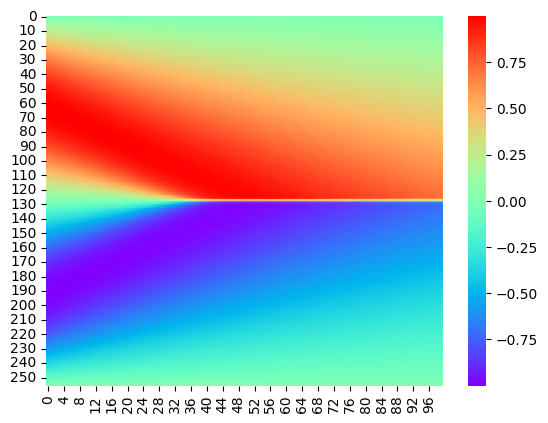

In [ ]:
sns.heatmap(u_exact, cmap='rainbow')

In [ ]:
criteria = nn.MSELoss()

In [ ]:
def physics_informed_loss(x, t, net):
    u = net(x, t)

    u_t = torch.autograd.grad(
        u, t,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True,
        allow_unused=True
    )[0]

    u_x = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True,
        allow_unused=True
    )[0]

    u_xx = torch.autograd.grad(
        u_x, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True,
        allow_unused=True
    )[0]

    pinn_loss = u_t + u * u_x - (0.01 / np.pi) * u_xx
    zeros_t = torch.zeros(pinn_loss.size()).to(device)
    pinn_loss_ = criteria(pinn_loss, zeros_t)
    return pinn_loss_

In [ ]:
def initial_condition_loss(x, t, net, u_ini):
    u = net(x, t)
    ini_condition_loss = criteria(u, u_ini)
    return ini_condition_loss

def boundary_condition_loss(x, t, net, u_bc):
    u = net(x, t)
    bc_condition_loss = criteria(u, u_bc)
    return bc_condition_loss


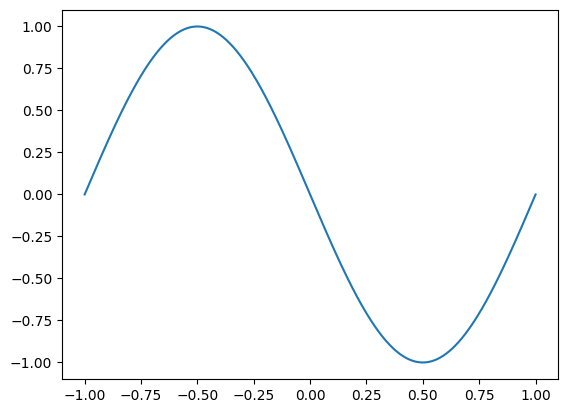

In [ ]:
ini_sample_size = 2000
x_ini = np.linspace(-1, 1, ini_sample_size)
X_ini = np.zeros([ini_sample_size, 2])
X_ini[:, 0] = x_ini
u_ini = -np.sin(np.pi * x_ini)
plt.plot(x_ini, u_ini)

X_ini_t = torch.tensor(X_ini, requires_grad=True).float().to(device)
u_ini_t = torch.tensor(u_ini, requires_grad=True).float().to(device).unsqueeze(dim=1)


In [ ]:
x_bc = np.array([-1.0, 1.0])
bc_sample_size = 200
t_bc = np.linspace(0, 1.0, bc_sample_size)

# x = -1.0
X_bc1 = np.zeros([bc_sample_size, 2])
X_bc1[:, 0] = -1.0
X_bc1[:, 1] = t_bc

# x = 1.0
X_bc2 = np.zeros([bc_sample_size, 2])
X_bc2[:, 0] = 1.0
X_bc2[:, 1] = t_bc

# stack
X_bc_stack = np.vstack([X_bc1, X_bc2])
u_bc_stack = np.zeros(X_bc_stack.shape[0])

X_bc_t = torch.tensor(X_bc_stack, requires_grad=True).float().to(device)
u_bc_t = torch.tensor(u_bc_stack, requires_grad=True).float().to(device).unsqueeze(dim=1)

In [ ]:
# sampling point
x_ = np.linspace(-1, 1, 100)
t_ = np.linspace(0, 1, 100)
X, T = np.meshgrid(x_, t_, indexing='ij')
x_flat = X.flatten()
t_flat = T.flatten()

# sampling size
sampling_size = 5000
random_idx = np.random.choice(np.arange(x_flat.shape[0]), size=sampling_size,replace=False)

#
# sampling
#
x_sampled = x_flat[random_idx]
t_sampled = t_flat[random_idx]
X_sampled = np.zeros([sampling_size, 2])
X_sampled[:, 0] = x_sampled
X_sampled[:, 1] = t_sampled
X_sample_t = torch.tensor(X_sampled, requires_grad=True).float().to(device)


In [ ]:
class PINN(torch.nn.Module):
    def __init__(self, activation='relu'):
        super().__init__()
        self.regressor = nn.Linear(5, 1)
        self.activation = activation
        self.linear1 = self.linear(2, 5, activation=self.activation)
        self.linear2 = self.linear(5, 20, activation=self.activation)
        self.linear3 = self.linear(20, 40, activation=self.activation)
        self.linear4 = self.linear(40, 40, activation=self.activation)
        self.linear5 = self.linear(40, 40, activation=self.activation)
        self.linear6 = self.linear(40, 20, activation=self.activation)
        self.linear7 = self.linear(20, 10, activation=self.activation)
        self.linear8 = self.linear(10, 5, activation=self.activation)

    def linear(self, in_features, out_features, activation='relu'):
        layers = [nn.Linear(in_features, out_features)]
        if activation == 'relu':
            layers.append(nn.ReLU(inplace=True))
        elif activation == 'tanh':
            layers.append(nn.Tanh())
        else:
            layers.append(nn.Sigmoid())
        net = nn.Sequential(*layers)
        return net

    def forward(self, x, t):
        inputs = torch.cat([x, t], axis=1)
        out = self.linear1(inputs)
        out = self.linear2(out)
        out = self.linear3(out)
        out = self.linear4(out)
        out = self.linear5(out)
        out = self.linear6(out)
        out = self.linear7(out)
        out = self.linear8(out)
        out = self.regressor(out)
        return out

In [ ]:
net = PINN(activation='tanh').to(device)
optimizer = optim.Adam(net.parameters(), lr=0.0005)

In [ ]:
num_epochs = 9000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    #
    # PINN loss
    #
    x_sampled = X_sample_t[:, 0].unsqueeze(dim=-1).to(device)
    t_sampled = X_sample_t[:, 1].unsqueeze(dim=-1).to(device)
    pinn_loss = physics_informed_loss(x_sampled, t_sampled, net)
    #
    # initial loss
    #
    x_ini = X_ini_t[:, 0].unsqueeze(dim=-1).to(device)
    t_ini = X_ini_t[:, 1].unsqueeze(dim=-1).to(device)
    ini_loss = initial_condition_loss(x_ini, t_ini, net, u_ini_t)
    #
    # bc loss
    #
    x_bnd = X_bc_t[:, 0].unsqueeze(dim=-1).to(device)
    t_bnd = X_bc_t[:, 1].unsqueeze(dim=-1).to(device)
    bnd_loss = boundary_condition_loss(x_bnd, t_bnd, net, u_bc_t)

    loss = pinn_loss + ini_loss + bnd_loss
    loss.backward()
    optimizer.step()
    if epoch % 500 == 0:
        loss_ = loss.item()
        pinn_loss_ = pinn_loss.item()
        ini_loss_ = ini_loss.item()
        bnd_loss_ = bnd_loss.item()
        print(f'epoch: {epoch:.3e}, loss:{loss_:.3e}, pinn:{pinn_loss_:.3e}, ini: {ini_loss_:.3e}, bnd:{bnd_loss_:.3e}')



epoch: 0.000e+00, loss:6.742e-01, pinn:3.678e-06, ini: 5.871e-01, bnd:8.708e-02
epoch: 5.000e+02, loss:1.213e-01, pinn:4.355e-02, ini: 7.214e-02, bnd:5.591e-03
epoch: 1.000e+03, loss:1.868e-02, pinn:8.582e-03, ini: 9.949e-03, bnd:1.541e-04
epoch: 1.500e+03, loss:5.411e-03, pinn:2.124e-03, ini: 3.244e-03, bnd:4.379e-05
epoch: 2.000e+03, loss:3.305e-03, pinn:1.198e-03, ini: 2.085e-03, bnd:2.300e-05
epoch: 2.500e+03, loss:2.669e-03, pinn:9.086e-04, ini: 1.749e-03, bnd:1.217e-05
epoch: 3.000e+03, loss:2.227e-03, pinn:6.532e-04, ini: 1.566e-03, bnd:7.687e-06
epoch: 3.500e+03, loss:2.924e-03, pinn:1.577e-03, ini: 1.328e-03, bnd:1.841e-05
epoch: 4.000e+03, loss:3.289e-03, pinn:1.180e-03, ini: 2.102e-03, bnd:6.526e-06
epoch: 4.500e+03, loss:2.605e-03, pinn:8.674e-04, ini: 1.732e-03, bnd:5.727e-06
epoch: 5.000e+03, loss:2.313e-03, pinn:8.102e-04, ini: 1.499e-03, bnd:3.518e-06
epoch: 5.500e+03, loss:2.202e-03, pinn:5.908e-04, ini: 1.574e-03, bnd:3.711e-05
epoch: 6.000e+03, loss:1.695e-03, pinn:5

In [ ]:
X_test = np.zeros([x_flat.shape[0], 2])
X_test[:, 0] = x_flat
X_test[:, 1] = t_flat

X_test_t = torch.tensor(X_test).float().to(device)
x_test = X_test_t[:, 0].unsqueeze(dim=-1)
t_test = X_test_t[:, 1].unsqueeze(dim=-1)
u_pred = net(x_test, t_test)

In [ ]:
u_pred_arr = u_pred.detach().cpu().numpy().reshape(100, 100)

<Axes: title={'center': 'Exact'}>

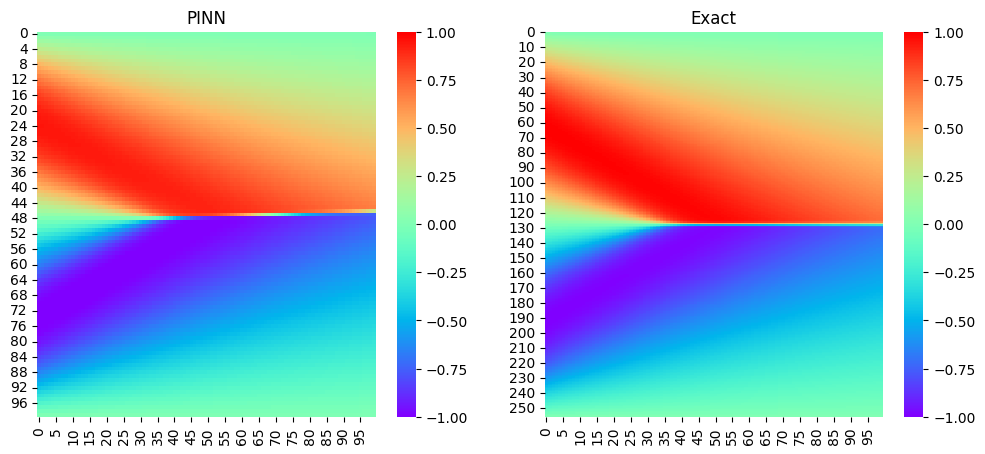

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('PINN')
sns.heatmap(u_pred_arr, cmap='rainbow', vmin=-1, vmax=1)
plt.subplot(1, 2, 2)
plt.title('Exact')
sns.heatmap(u_exact, cmap='rainbow', vmin=-1, vmax=1)